# How to Beat Better Rated Chess Players

### Tutorial by Vishwa Shanmugam

## Motivation
Online chess has become a very popular pastime, with services like https://lichess.org/ and https://www.chess.com/ typically having over hundreds of thousands of active users at a time. The usual goal for players on these websites is to increase their ELO rating, which is a qualitative measure of chess skill. Within matchmaking constraints, players tend to play others within a certain ELO ranking of theirs, which of course means they at times play players both better and worse than them by some amount. This provides an obvious motivation; how do you beat players with a higher ranking than you?

The strategies and tactics used in chess games often depend on the openings used by players; the sequence of the first few moves they take that are often memorized and played quickly. These openings tend to give way to certain sorts of structures and can dictate the pace and flow of the game, either giving way to a quickly moving game with lots of piece taking and room for clever tactics, or a slow, grindy game where the focus is on optimizing piece positions and exploiting weaknesses. Given how different two games can be depending on the opening used, I was interested in which strategies were most likely to take a win over a better opponent. I chose to restrict our analysis to the white pieces; as you can see later on, chess is asymmetric with respect to the color you play with, so this analysis can't generalize to both colors easily.

## The Data
We will be using a dataset from Lichess. Lichess offers its own database of played games, but these databases are in a format meant for chess engines to read, PGN files, which adds a lot of work on our end to translate them to a Python readable format. Also, these databases are huge! The last month's data alone was 18 gigabytes of data, before unzipping, which a) didn't fit on my disk and b) would slow our pipeline down considerably. To mitigate this, we will instead use a user-curated CSV format dataset of around 20k games, available on Kaggle [here](https://www.kaggle.com/datasnaek/chess?select=games.csv). The sample is not totally random, but are instead taken from a sample of players on "Lichess teams", which the dataset creator used to scrape. While this will likely introduce some biases, they should not be so severe as to compromise the conclusions. 

In [137]:
import pandas as pd
import seaborn as sns

We will be doing a lot of the data processing work using [pandas](https://pandas.pydata.org/docs/getting_started/index.html), a Python library that makes working with table-style data much much easier. We can use Pandas to clean our data and work with [Seaborn](https://seaborn.pydata.org/index.html) to easily visualize it before we start the brunt of our data analysis work.

In [138]:
chess = pd.read_csv("games.csv") #read in data from CSV
chess.head(5)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


After using standard Pandas functions to read in a CSV to a dataframe (the table data structure visualized above), we can call head(n) to view the first n rows. We see 16 columns in this dataset:
* id: The internal Lichess game id
* rated: If the game was played with rating points on the line
* created_at and last_move_at: The start and end times, respectively, of the game
* turns: The number of turns before the game ended
* victory_status: How the win was achieved; notable ones for our purposes include "mate" (the loser was placed in checkmate), "resign" (the loser resigned), "outoftime" (the loser ran out of time to make their moves; often referred to as "flagging") and "draw" (users agreed to a draw).
* winner: The winner, by color of pieces (or "draw" if the game was drawn)
* increment code: The amount of time the users played with. In format x + y, x refers to the number of minutes players start with, and y refers to the number of seconds they gain every time they make a move. Common formats include 1 + 0 ("bullet"), 3 + 0 or 5 + 0 ("blitz"), and 10 + something ("rapid")
* white/black id: The lichess username of the white/black player
* white/black rating: The lichess ELO of the white/black player
* moves: A complete list of moves played in the game, given in [algebraic notation](https://en.wikipedia.org/wiki/Algebraic_notation_(chess)) (see [here](https://www.chess.com/article/view/chess-notation) for a more detailed explanation)
* opening_eco: A standardized short code for openings; see [list of ecos](https://www.365chess.com/eco.php)
* opening_name: The common referrent for the opening name; Openings are referred to by both a general opening name and a variation name after (e.g. Italian Game: Schilling-Kostic Gambit means the Schilling-Kostic Gambit variation of the Italian Game.)
* opening_ply: The number of moves considered to be played in the opening.

## Data Cleaning


In [139]:
chess = chess.dropna(); #drop entries that are NaN
chess['rated'] = chess['rated'].astype(str) #in the CSV, this isn't treated as a string for some reason?
chess = chess[chess.rated=="True"]
chess = chess[chess.winner!="draw"]
chess = chess.drop(columns=["id", "created_at", "last_move_at", "rated"])

chess.head(5)

,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
1,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5
6,33,resign,white,10+0,capa_jr,1520,daniel_likes_chess,1423,d4 d5 e4 dxe4 Nc3 Nf6 f3 exf3 Nxf3 Nc6 Bb5 a6 ...,D00,Blackmar-Diemer Gambit: Pietrowsky Defense,10



While all of the data given in the original table could be useful for some applications, we have a fairly set procedure in mind, and so extraneous data could slow down processing and make viewing the relevant data more difficult. We did two different types of data cleaning; removing columns (data we don't need at all to do our work) and removing rows (removing instances of the data that are problematic somehow.) 

dropna() drops any rows that don't have all of their data filled out completely. Then, we used indexing to only get rows with certain properties; we only get games that are rated, and games that didn't end in draws. With unrated games, its impossible to tell how seriously players were playing, so this may introduce outliers into the data. Since we are primarily looking for strategies to improve rating, it is fairly safe to drop unrated games. We also drop games that end in a draw; later on, this will make it possible to do logistic regression by creating a binary variable (if white won or lost.) Finally, we dropped some columns that aren't necessary anymore; we don't care about when the game happened or what id it had, and since rated is always true now, we don't need to have that column.

In [140]:
chess.insert(2, "white_won", 0)
chess.insert(11, "short_opening", "")
chess.insert(9, "rating_diff", 0) #add new columns that we will populate

for index, row in chess.iterrows():
    white_won = 1 if row["winner"] == "white" else 0 
    chess.at[index, "white_won"] = white_won
    full_opening_name = row["opening_name"]
    opening = full_opening_name.split(":")[0]
    opening = opening.split("|")[0]
    opening = opening.split("#")[0]
    opening = opening.strip(); #String transformation to just get base opening name
    if opening == "Queen's Pawn":
        opening = "Queen's Pawn Game"
        
    chess.at[index, 'short_opening'] = opening
    diff = row["white_rating"] - row["black_rating"];
    chess.at[index, "rating_diff"] = diff;

chess.drop(columns=["winner"]) 

,turns,victory_status,white_won,increment_code,white_id,white_rating,black_id,black_rating,rating_diff,moves,opening_eco,short_opening,opening_name,opening_ply
1,16,resign,0,5+10,a-00,1322,skinnerua,1261,61,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense,Nimzowitsch Defense: Kennedy Variation,4
2,61,mate,1,5+10,ischia,1496,a-00,1500,-4,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game,King's Pawn Game: Leonardis Variation,3
3,61,mate,1,20+0,daniamurashov,1439,adivanov2009,1454,-15,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game,Queen's Pawn Game: Zukertort Variation,3
4,95,mate,1,30+3,nik221107,1523,adivanov2009,1469,54,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,Philidor Defense,5
6,33,resign,1,10+0,capa_jr,1520,daniel_likes_chess,1423,97,d4 d5 e4 dxe4 Nc3 Nf6 f3 exf3 Nxf3 Nc6 Bb5 a6 ...,D00,Blackmar-Diemer Gambit,Blackmar-Diemer Gambit: Pietrowsky Defense,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20053,24,resign,1,10+10,belcolt,1691,jamboger,1220,471,d4 f5 e3 e6 Nf3 Nf6 Nc3 b6 Be2 Bb7 O-O Be7 Ne5...,A80,Dutch Defense,Dutch Defense,2
20054,82,mate,0,10+0,jamboger,1233,farrukhasomiddinov,1196,37,d4 d6 Bf4 e5 Bg3 Nf6 e3 exd4 exd4 d5 c3 Bd6 Bd...,A41,Queen's Pawn Game,Queen's Pawn,2
20055,35,mate,1,10+0,jamboger,1219,schaaksmurf3,1286,-67,d4 d5 Bf4 Nc6 e3 Nf6 c3 e6 Nf3 Be7 Bd3 O-O Nbd...,D00,Queen's Pawn Game,Queen's Pawn Game: Mason Attack,3
20056,109,resign,1,10+0,marcodisogno,1360,jamboger,1227,133,e4 d6 d4 Nf6 e5 dxe5 dxe5 Qxd1+ Kxd1 Nd5 c4 Nb...,B07,Pirc Defense,Pirc Defense,4


Some more cleaning: It's nice to have numeric data for later purposes, so we convert winner into a binary variable - 1 if white won, and 0 if black won. We can then drop the winner column, as we have the same data in another column now (remember, there are no more draws in the dataset).

The next step is to deal with the openings. Since there are so many variations for each type of opening, we will probably end up with fairly small sample sizes for each individual opening, which will be hard to work with. We instead roll each every variation into their top level classification. In this case, we leave the original column, as it has more information that might be useful to us later. We also specifically change instances of Queen's Pawn to Queen's Pawn Game, since this isn't standardized in the dataset.

Finally, we transform the two ratings into a difference of ratings, which can be more useful to plot and work with later on.

We've done a lot of transformation to our dataset, so let's step back and take a look at what we have to work with:

## Exploratory Analysis & Data Visualization


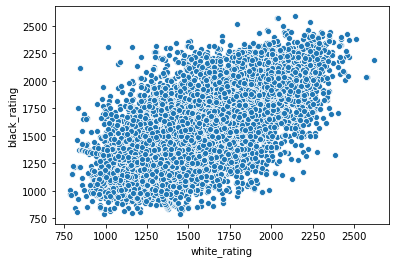

In [141]:
sns.scatterplot(data=chess, x="white_rating", y="black_rating")

Here's a fairly messy view of all of our games by the ratings of the players. We expect the data to be roughly centered around y=x, as players of similar skills should typically be playing each other. The width of the data shows that there are a good number of high rating difference gamaes in our dataset, which is good for our analysis. As an aside, you can really see how useful and quick Seaborn is for rough data visualization.

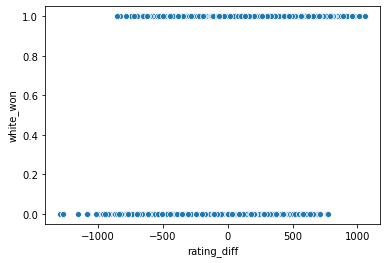

In [142]:
sns.scatterplot(data=chess, x="rating_diff", y="white_won")

Here, we use rating diff column we created to be able to easily plot the diff against winning. Points on the bottom represent a game where white lost and points on the top represent a game where white won. Points on the right indicate that white was higher rated than their opponent, while points on the left mean white was lower rated. Points where x is < 0 and white_won is 1 are points with an "unexpected" result (the lower rated player won) and the same is true where x > 0 and white_won is 0. It seems that there are quite a number of these unexpected points to examine, though its hard to tell how common these victories are due to the clustering of points. Let's fix that:


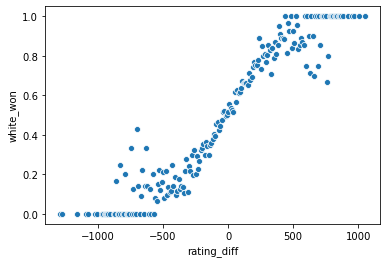

In [143]:
chess_new = chess
for index, row in chess_new.iterrows():
    chess_new.at[index, "rating_diff"] = row["rating_diff"] - (row["rating_diff"] % 10)

mean = chess_new.groupby(["rating_diff"]).mean()
mean = mean.reset_index();
sns.scatterplot(data=mean, x="rating_diff", y="white_won")

To get around this, we can use the mean of games by rating to determine how likely white is to win a certain rating differences. To avoid modifying the original data, we create a temporary new dataframe to do this transformation on. Since rating_diff can take on a lot of different values, it's easiest to group them into buckets of size 10 so that most buckets have more than one result. From there, we group the data by the rating difference and find the "average" of the variable white_won. This translates to the probability white will win a game at that rating difference. There are some outlier effects, which are likely due to low sample sizes of games at those extreme rating differences. Notably, this graph looks somewhat like a logistic curve, a fact we will take advantage of later on.

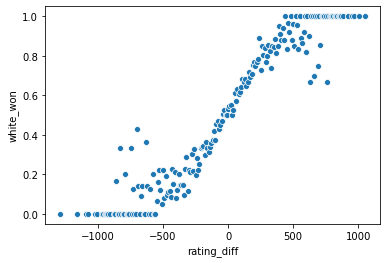

In [144]:
chess_new = chess_new[chess_new.victory_status != "outoftime"];
mean = chess_new.groupby(["rating_diff"]).mean()
mean = mean.reset_index();
sns.scatterplot(data=mean, x="rating_diff", y="white_won")

As a for-fun hypothesis, I wondered if those outliers would disappear if we removed losses due to the timer, but this doesn't seem to be the case. (A common chess joke is calling winning by the timer "dirty flagging," as there is a whole art to making moves that make your opponent have to spend as much time as possible to respond to them, which can result in them losing on time even if they are objectively much more likely to win based on board position.)

Anyways, we've had enough fun with graphs for now, so lets move on to more serious analysis.

In [145]:
import numpy as np
from sklearn.linear_model import LogisticRegression

[NumPy](https://numpy.org/) and [scikit-learn](https://scikit-learn.org/stable/) are two heavy hitting Python libraries for data analysis. NumPy provides intuitive multi-dimensional array creation and many scientific math functions, while scikit-learn provides a lot of machine learning and regression tools to use. 

We're going to start by doing logistic regression on the data. Logistic regression takes a continuous variable and a binary variable, and uses the data to output a model that represents how the continuous variable affects the likelihood of the binary variable. Essentially, we're given a formula that lets us answer "at some value of x, how likely is y to occur?" For our case, we'll be using rating difference to predict the probability that white wins. If you want a more thorough explanation of logistic regression, read [here](https://machinelearningmastery.com/logistic-regression-for-machine-learning/). For a more involved tutorial on doing logistic regression using sklearn, read [here](https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a). We'll be training our model on our data and using it to figure out the likelihood at various rating differences that white wins.

In [146]:
X = chess["rating_diff"].to_numpy().reshape(-1, 1) #reshape needed as X data is one-dimensional
y = chess["white_won"].to_numpy()
clf = LogisticRegression(random_state=0).fit(X, y) #get the logistic regression model
vals = np.array([-200, -100, 0, 100, 200]).reshape(-1, 1) #small sample of points to get a feel for the model
predicts = clf.predict_proba(vals)
predicts

array([[0.68567602, 0.31432398],
       [0.58414346, 0.41585654],
       [0.47492892, 0.52507108],
       [0.36806122, 0.63193878],
       [0.27274934, 0.72725066]])

Logistic regression nicely gives us the probability of winning at various rating differences (read the data as \[probability black wins, probability white wins\]) For instance, if White is down 200 rating points on their opponent, we would expect they win around 31.5% of the time if we have no other knowledge about the game. As a side note, you can see that even at supposedly equal skill (0 rating difference), there is a tilt in white's favor; this is fairly well known as a consequence of chess's ruleset, in which being able to move first gives the white player an advantage. We'll have to take note of this fact later on, but this is one reason why we're restricting our question to white-favored openings.

Anyways, this model is a useful baseline for us. We can consider these results as the "average performance" at various skill levels; so we can see which openings lead to more white-advantaged or white-disadvantaged performances by comparing against this standard. We're going to look at every opening in turn and compare against these numbers.

In [147]:
chess_high_diff = chess[chess.rating_diff < -100] #only get openings that have been played at a big rating disadvantage for white
listOfOpenings = np.unique(chess_high_diff["short_opening"].to_numpy()).tolist();
removeList = [];
for opening in listOfOpenings:
    chess_op = chess_high_diff[chess_high_diff.short_opening == opening]
    if len(chess_op) < 5:
        removeList.append(opening)

for remove in removeList:
    listOfOpenings.remove(remove) #Do this all in one shot to avoid unexpected behavior from for..in 
                                  #loops where we delete a member during the loop execution
        
listOfOpenings

['Alekhine Defense',
 'Amar Opening',
 'Benoni Defense',
 'Bird Opening',
 "Bishop's Opening",
 'Blackmar-Diemer Gambit',
 'Budapest Defense',
 'Caro-Kann Defense',
 'Center Game',
 'Colle System',
 'Danish Gambit',
 'Danish Gambit Accepted',
 'Dutch Defense',
 'Elephant Gambit',
 'English Defense',
 'English Opening',
 'Englund Gambit',
 'Englund Gambit Declined',
 'Four Knights Game',
 'French Defense',
 "Gedult's Opening",
 'Giuoco Piano',
 'Grob Opening',
 'Gruenfeld Defense',
 'Horwitz Defense',
 'Hungarian Opening',
 'Indian Game',
 'Italian Game',
 'Kadas Opening',
 "King's Gambit",
 "King's Gambit Accepted",
 "King's Gambit Declined",
 "King's Indian Attack",
 "King's Indian Defense",
 "King's Knight Opening",
 "King's Pawn Game",
 "King's Pawn Opening",
 'London System',
 'Mieses Opening',
 'Modern Defense',
 'Nimzo-Indian Defense',
 'Nimzo-Larsen Attack',
 'Nimzowitsch Defense',
 'Old Benoni Defense',
 'Old Indian Defense',
 'Owen Defense',
 "Petrov's Defense",
 'Philidor Def

We use some numpy tricks to easily get a list of all of the openings. We restrict the search to openings played where at least 5 games were played with white at least 100 points down on their opponents; otherwise, its likely that the small sample size of games at the extreme end will make the regression inaccurate. We're left with a collection of openings used fairly frequently, with known data on high skill difference matchups.

## Machine Learning + Hypothesis testing

In [148]:
from scipy import stats

vals = np.array(range(-200,-50)).reshape(-1, 1)
predicts = clf.predict_proba(vals);
openings_performances = {};
for opening in listOfOpenings:
    chess_op = chess[chess.short_opening == opening]
    X = chess_op["rating_diff"].to_numpy().reshape(-1, 1)
    y = chess_op["white_won"].to_numpy()
    if len(np.unique(y).tolist()) == 1: #we can only use openings with which white has both won and lost.
        continue
    op_clf = LogisticRegression(random_state=0).fit(X, y)
    op_predicts = op_clf.predict_proba(vals) 
    win_diff = (np.subtract(op_predicts, predicts)) #the second column of this matrix is the improvement the opening provides at 150 differeent rating differences
    t, p = stats.ttest_rel(op_predicts[:,1], predicts[:,1]); #perform a t test to check if the opening provides significantly different results
    print("p={} for {}".format(p, opening)) 
    if(p < 0.05):
        print("statistically significant")
        print(np.sum(win_diff, axis=0)[1] / len(vals))
        openings_performances[opening] = np.sum(win_diff, axis=0)[1] / len(vals)
    else:
        print("not statistically significant")
    print()

p=5.969036215735153e-111 for Alekhine Defense
statistically significant
-0.09078673333539004

p=3.851347487993993e-199 for Amar Opening
statistically significant
0.10051582112597683

p=5.101894984352336e-37 for Benoni Defense
statistically significant
0.06589841655831469

p=4.419842286070625e-186 for Bird Opening
statistically significant
-0.11556239011254017

p=2.8342310732105735e-137 for Bishop's Opening
statistically significant
0.0742254414941556

p=1.5205506083132011e-86 for Blackmar-Diemer Gambit
statistically significant
-0.030521803721069

p=9.841618689418703e-70 for Budapest Defense
statistically significant
-0.14979607603740638

p=7.63850974401928e-73 for Caro-Kann Defense
statistically significant
-0.01637487457439888

p=1.5410742199426433e-110 for Center Game
statistically significant
-0.07280690133875418

p=3.60670359263661e-171 for Colle System
statistically significant
-0.16818498734924806

p=2.052768603072491e-217 for Danish Gambit
statistically significant
-0.059619910

We had to check to make sure every opening had two different outcomes (i.e. not all games were white wins or vice versa), as otherwise logistic regression wouldn't work. 

We need a good way to determine which openings perform "better than average" at rating differences where white is down (that is the point of this exercise!) We can roughly estimate this by taking predictions at 6 different points where white is down in rating and comparing the differences between the opening's win percent at this rating difference and the general win percent at this rating difference, then summing the differences at these 6 points. While this isn't the most scientific approach, this helps narrow our search down to a few key openings that we can then compare in more detail. We also use a [paired t-test](https://www.statisticssolutions.com/manova-analysis-paired-sample-t-test/#:~:text=The%20paired%20sample%20t%2Dtest,resulting%20in%20pairs%20of%20observations.) to determine if these openings are significantly different from the average chance of winning (i.e. if we can conclude these openings provide significantly different odds of winning from the average chance of winning at this range of rating differences). Almost all of the openings were found to be significantly different, which makes sense as openings tend to have a very large impact on gameplay. For these openings, I also printed out the "average increase in winning percentage" given by playing that opening. For instance, playing the Bird Opening on average makes you ~11% less likely to win when you are at a disadvantage in chess skill. The 10 most winning openings at these difficulties are below:

In [149]:
import operator #used to easily sort a dict
sorted_performances = sorted(openings_performances.items(), key=operator.itemgetter(1), reverse=True);
print(sorted_performances[0:10])


[('Danish Gambit Accepted', 0.21686056123481592), ('Elephant Gambit', 0.1964445164077559), ("King's Indian Attack", 0.1864461005103018), ('Nimzowitsch Defense', 0.18456045367297585), ("King's Knight Opening", 0.13464491501852402), ("Queen's Gambit Refused", 0.13417351528659568), ('Reti Opening', 0.11027335808693176), ('Amar Opening', 0.10051582112597683), ('Robatsch (Modern) Defense', 0.09015517596211209), ('Yusupov-Rubinstein System', 0.08748695125447845)]


These results intuitively make sense; most of these openings are fairly uncommon and not considered actually good at a high level. Of course, in online chess this works perfectly to their advantage; these openings tend to be less studied and so the opponent is much more likely to fall into any traps and tricks that the opening user can employ. This is also why it's unsurprising to a few gambits here; those tend to create lots of fast moving, exciting games. These results aren't all helpful to white, however; for instance, it is black who chooses whether or not to enter the Nimzowitsch defense on their first move of the game. Similarly, the Elephant Gambit involves black gambiting, rather than White. The Danish Gambit, King's Indian Attack, and King's Knight Openings are all openings that white can choose to go into, though white cannot force black into accepting the Danish Gambit.

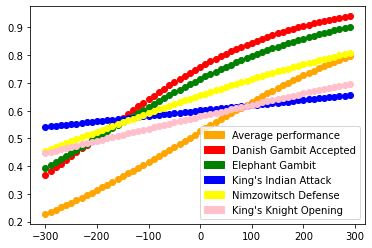

In [150]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

vals = []
for i in range(-300, 300, 10):
    vals.append(i);
vals = np.array(vals).reshape(-1, 1)


clf_curve = clf.predict_proba(vals)[:,1]
plt.plot(vals, clf_curve, 'o', color='orange')
patch1 = mpatches.Patch(color='orange', label='Average performance')
patch2 = mpatches.Patch(color='red', label='Danish Gambit Accepted')
patch3 = mpatches.Patch(color='green', label='Elephant Gambit')
patch4 = mpatches.Patch(color='blue', label='King\'s Indian Attack')
patch5 = mpatches.Patch(color='yellow', label='Nimzowitsch Defense')
patch6 = mpatches.Patch(color='pink', label='King\'s Knight Opening')

plt.legend(handles=[patch1,patch2,patch3,patch4,patch5,patch6])

colors = ["red", "green", "blue", "yellow", "pink"]
for i in range(0,5):
    chess_op = chess[chess.short_opening == sorted_performances[i][0]]
    X = chess_op["rating_diff"].to_numpy().reshape(-1, 1)
    y = chess_op["white_won"].to_numpy()
    op_clf = LogisticRegression(random_state=0).fit(X, y)
    new_curve = op_clf.predict_proba(vals)[:,1]
    plt.plot(vals, new_curve, 'o', color = colors[i])


Here is a set of scatter plots showing the relative win probability of all of the top 5 openings. The King's Indian Attack and King's Knight Opening are remarkably stable openings, performing near equally at basically every rating difference, while the other 3 tend to outperform the average at every reasonable rating difference.

We can do a similar analysis for black by noting that every time a lower player with the black pieces wins, a higher rated player with the white pieces loses. We use this, flip some negatives in the code, and subtract 1 from all the predicted values to convert from the probability white wins to the probability black wins


In [151]:
chess_high_diff = chess[chess.rating_diff > 100]
listOfOpenings = np.unique(chess_high_diff["short_opening"].to_numpy()).tolist();
removeList = [];
for opening in listOfOpenings:
    chess_op = chess_high_diff[chess_high_diff.short_opening == opening]
    if len(chess_op) < 5:
        removeList.append(opening)

for remove in removeList:
    listOfOpenings.remove(remove)
        
listOfOpenings
vals = np.array(range(50,200)).reshape(-1, 1)
predicts = clf.predict_proba(vals);
openings_performances = {};
for opening in listOfOpenings:
    chess_op = chess[chess.short_opening == opening]
    X = chess_op["rating_diff"].to_numpy().reshape(-1, 1)
    y = chess_op["white_won"].to_numpy()
    if len(np.unique(y).tolist()) == 1:
        continue
    op_clf = LogisticRegression(random_state=0).fit(X, y)
    op_predicts = op_clf.predict_proba(vals)
    win_diff = (np.subtract(op_predicts, predicts))
    t, p = stats.ttest_rel(op_predicts[:,1], predicts[:,1]);
    print("p={} for {}".format(p, opening))
    if(p < 0.05):
        print("statistically significant")
        print(np.sum(win_diff, axis=0)[0] / len(vals))
        openings_performances[opening] = np.sum(win_diff, axis=0)[0] / len(vals)
    else:
        print("not statistically significant")
    print()

p=1.7688739958453518e-60 for Alekhine Defense
statistically significant
-0.04416232250853719

p=8.379033667012817e-221 for Anderssen Opening
statistically significant
-0.21084354552901632

p=3.7218244967809106e-198 for Barnes Defense
statistically significant
-0.0524628314583387

p=1.3267034861568113e-103 for Benoni Defense
statistically significant
0.21051177824901346

p=1.802963739624713e-44 for Bird Opening
statistically significant
0.02955106974885478

p=3.7229523193273755e-243 for Bishop's Opening
statistically significant
-0.09711165493179995

p=1.1472575094648646e-82 for Blackmar-Diemer Gambit
statistically significant
-0.026021096869231385

p=4.489243739395663e-95 for Caro-Kann Defense
statistically significant
-0.0200093302125436

p=4.4648316496069607e-197 for Center Game
statistically significant
0.13923532219963922

p=5.553435522181327e-244 for Colle System
statistically significant
0.19560222147336948

p=1.8621420143786928e-175 for Danish Gambit Accepted
statistically signi

In [152]:
import operator
sorted_performances = sorted(openings_performances.items(), key=operator.itemgetter(1), reverse=True);
print(sorted_performances[0:10])

[('Benoni Defense', 0.21051177824901346), ('Colle System', 0.19560222147336948), ('Grob Opening', 0.1831795074092464), ('Center Game', 0.13923532219963922), ('Mikenas Defense', 0.13715769818740878), ('Van Geet Opening', 0.10628009189859165), ("Petrov's Defense", 0.09366931792097895), ('Mieses Opening', 0.09296020135067241), ('Englund Gambit Declined', 0.08574411449734626), ('Slav Defense', 0.07734595493410538)]


These openings are very different, as one would expect. They seem to favor much more defensive play than white did, interestingly.

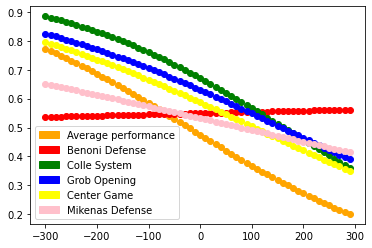

In [153]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

vals = []
for i in range(-300, 300, 10):
    vals.append(i);
vals = np.array(vals).reshape(-1, 1)


clf_curve = clf.predict_proba(vals)[:,1]
clf_curve = np.subtract(np.ones(len(clf_curve)), clf_curve)
plt.plot(vals, clf_curve, 'o', color='orange')
patch1 = mpatches.Patch(color='orange', label='Average performance')
patch2 = mpatches.Patch(color='red', label='Benoni Defense')
patch3 = mpatches.Patch(color='green', label='Colle System')
patch4 = mpatches.Patch(color='blue', label='Grob Opening')
patch5 = mpatches.Patch(color='yellow', label='Center Game')
patch6 = mpatches.Patch(color='pink', label='Mikenas Defense')

plt.legend(handles=[patch1,patch2,patch3,patch4,patch5,patch6])

colors = ["red", "green", "blue", "yellow", "pink"]
for i in range(0,5):
    chess_op = chess[chess.short_opening == sorted_performances[i][0]]
    X = chess_op["rating_diff"].to_numpy().reshape(-1, 1)
    y = chess_op["white_won"].to_numpy()
    y = np.subtract(np.ones(len(y)), y)
    op_clf = LogisticRegression(random_state=0).fit(X, y)
    new_curve = op_clf.predict_proba(vals)[:,1]
    plt.plot(vals, new_curve, 'o', color = colors[i])


Note that, in this plot, the y axis is the chance that black wins, but the rating difference is calculated from the white perspective; it's still white rating - black rating. 

## Conclusion
Using our plots, one can conclude that the King's Indian Attack and the Danish Gambit Accepted are the best openings for white to use at a disadvantage, with the King's Indian Attack performing better if you are more than 200 rating points behind. On the other side, we see the same pattern for the Benoni Defense and the Colle System. Of course, there are a lot of asterisks to assign to these conclusions, as we made a lot of simplifying conclusions that don't necessarily hold up. For one, we are using a much much smaller dataset than the total data available to us, and additionally, the dataset isn't the newest. Since new openings and preparations are often developed, it's possible that today, different openings might be optimal to beat better players. Additionally, we treated rating differences as equal no matter the base ratings, which may not be true. An opening that allows a 1200 rated player beat a 1400 rated player may not be the best for a 2200 player to employ against a 2400 rated player, for instance. This is likely one of the most flawed assumptions we implicitly made. We also didn't account for any of the other possible entangled explanatory variables from our analysis. It's possible that different time formats have different effects on letting lower rated players win, for instance, and we didn't control for how games were lost. Some games in the database may have been resigned due to, for instance, internet issues. It's difficult if not impossible to evaluate when this happens, so these can provide outliers in the data, but on the other hand it's likely a source of bias if we only count games ending in checkmates. 

A lot of these problems stem either from the limited scope of our investigation or the small amount of data available to us. I believe the procedures and methods in this tutorial could definitely be applied to a larger dataset that has been more carefully curated (for instance, removing any games lost on time, or any games under 10 moves, or only considering ratings between 1000 and 1500) to get more specialized and tailored recommendations for your specific situation. If you, a 1200 rated player, wanted to figure out the opening that performs best on players rated around 1400 while playing with the black pieces, you could definitely do that with this general pipeline and more data! Hopefully, you use this tutorial as a jumping-off point, because there is so much left to explore and so much data available with which to do it.

Some other questions I would answer with a lot more time to do it:
   * Which time formats are the best for lower rated players to win in?
   * What openings are the most likely to lead to a player losing on time?
   * What are the most consistent openings to beat lower rated players with?
   * What happens in the case of some gambits not being accepted? (Does playing a Danish Gambit as white and having it be declined significantly hurt your odds of winning?)
   * Instead of using win/loss as the predictor, can we do linear regression with, say, a chess engine's evaluation some number moves into the game as the y variable?